# Training Notebook

## Imports and install

In [181]:
# Imports
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import umap

In [7]:
# Install sqlite as a extension of duckdb
#duckdb.install_extension('sqlite')

## Extract data

In [3]:
# create a connection to a file called 'file.db'
con = duckdb.connect("../data/train/diamonds_train.db")

In [42]:
# Obtain the names of the tables
result = con.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = result.fetchdf()
print(tables)

                     name
0     diamonds_dimensions
1  diamonds_transactional
2     diamonds_properties
3            diamonds_cut
4          diamonds_color
5        diamonds_clarity
6           diamonds_city


#### Query test

In [9]:
# Query test
result = con.execute("SELECT * FROM diamonds_properties").df()
result.head()

,index_id,cut_id,color_id,clarity_id
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,de88c121a82a06352bf1aaceba20578356408a334ba046...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...


In [23]:
# Query to extract one part of data
# pro = diamonds_properties
# cut = diamonds_cut
# col = diamonds_color
# cla = diamonds_clarity

query = """
SELECT
    pro.index_id,
    cut.cut,
    col.color,
    cla.clarity
FROM diamonds_properties AS pro
JOIN diamonds_cut AS cut ON pro.cut_id = cut.cut_id
JOIN diamonds_color AS col ON pro.color_id = col.color_id
JOIN diamonds_clarity AS cla ON pro.clarity_id = cla.clarity_id
"""

result = con.execute(query).df()
result.head()

,index_id,cut,color,clarity
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,Premium,J,VS2
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,Very Good,H,VS2
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,Fair,G,VS1
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,Good,D,SI1
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,Ideal,G,SI1


In [27]:
# Query to extract another part of data
# tra = diamonds_transactional
# cit = diamonds_city

query2 = """
SELECT
    tra.index_id,
    tra.price,
    cit.city,
    tra.carat
FROM diamonds_transactional AS tra
JOIN diamonds_city AS cit ON tra.city_id = cit.city_id
"""

result2 = con.execute(query2).df()
result2.head()

,index_id,price,city,carat
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,4268,Dubai,1.21
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,505,Kimberly,0.32
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,2686,Las Vegas,0.71
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,738,Kimberly,0.41
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,4882,Dubai,1.02


####  The full query

In [110]:
# pro = diamonds_properties
# cut = diamonds_cut
# col = diamonds_color
# cla = diamonds_clarity
# tra = diamonds_transactional
# cit = diamonds_city
# dim = diamonds_dimensions

query_full = """
SELECT
    --tra.index_id,
    cut.cut,
    col.color,
    cla.clarity,
    tra.price,
    cit.city,
    tra.carat,
    dim.depth,
    dim.table,
    dim.x,
    dim.y,
    dim.z
FROM diamonds_properties AS pro
JOIN diamonds_cut AS cut ON pro.cut_id = cut.cut_id
JOIN diamonds_color AS col ON pro.color_id = col.color_id
JOIN diamonds_clarity AS cla ON pro.clarity_id = cla.clarity_id
JOIN diamonds_transactional as tra ON pro.index_id = tra.index_id
JOIN diamonds_city AS cit ON tra.city_id = cit.city_id
JOIN diamonds_dimensions AS dim ON pro.index_id = dim.index_id
"""

diamond_df = con.execute(query_full).df()
diamond_df.head()

,cut,color,clarity,price,city,carat,depth,table,x,y,z
0,Premium,J,VS2,4268,Dubai,1.21,62.4,58.0,6.83,6.79,4.25
1,Very Good,H,VS2,505,Kimberly,0.32,63.0,57.0,4.35,4.38,2.75
2,Fair,G,VS1,2686,Las Vegas,0.71,65.5,55.0,5.62,5.53,3.65
3,Good,D,SI1,738,Kimberly,0.41,63.8,56.0,4.68,4.72,3.00
4,Ideal,G,SI1,4882,Dubai,1.02,60.5,59.0,6.55,6.51,3.95


#### Extract test data

In [225]:
diamonds_test = pd.read_csv("../data/test/diamonds_test.csv")
diamonds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13485 entries, 0 to 13484
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13485 non-null  int64  
 1   carat    13485 non-null  float64
 2   cut      13485 non-null  object 
 3   color    13485 non-null  object 
 4   clarity  13485 non-null  object 
 5   depth    13485 non-null  float64
 6   table    13485 non-null  float64
 7   x        13485 non-null  float64
 8   y        13485 non-null  float64
 9   z        13485 non-null  float64
 10  city     13485 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.1+ MB


## Data analysis 
It is possible to observe different things about the data:
- The values in the x,y,z columns take the value 0 in some cases, this may cause problems. There would be two ways to solve this: deleting the records or imputing them.
- Observe if there are error values in the categorical variables.
- On the other hand, there are some outliers, which can be removed or not.
- It can be observed that there are some repeated records.
- View the distribution of the records in the categorical variables

In [121]:
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      40455 non-null  object 
 1   color    40455 non-null  object 
 2   clarity  40455 non-null  object 
 3   price    40455 non-null  int64  
 4   city     40455 non-null  object 
 5   carat    40455 non-null  float64
 6   depth    40455 non-null  float64
 7   table    40455 non-null  float64
 8   x        40455 non-null  float64
 9   y        40455 non-null  float64
 10  z        40455 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [55]:
diamond_df.describe()

,price,carat,depth,table,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154
std,3992.416147,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


In [56]:
diamond_df.shape

(40455, 11)

In [78]:
# Detect if there is zero in x, y and z columns
def zero_count(df):
    num_zeros_x = (df['x'] == 0).sum()
    num_zeros_y = (df['y'] == 0).sum()
    num_zeros_z = (df['z'] == 0).sum()

    print("Número de ceros en la columna 'x':", num_zeros_x)
    print("Número de ceros en la columna 'y':", num_zeros_y)
    print("Número de ceros en la columna 'z':", num_zeros_z)
    
zero_count(diamond_df)

Número de ceros en la columna 'x': 5
Número de ceros en la columna 'y': 4
Número de ceros en la columna 'z': 16


In [120]:
# Detect if there are errors in the categorical clases  clarity city
def categorical_errors(df):
    cut_unique = df['cut'].unique().tolist()
    color_unique = df['color'].unique().tolist()
    clarity_unique = df['clarity'].unique().tolist()
    city_unique = df['city'].unique().tolist()
    
    print("Los tipos diferentes de corte son: ", cut_unique)
    print("Los diferentes colores son: ", color_unique)
    print("Los diferentes colores son: ", clarity_unique)
    print("Los diferentes colores son: ", city_unique)
    
categorical_errors(diamond_df)

Los tipos diferentes de corte son:  ['Premium', 'Very Good', 'Fair', 'Good', 'Ideal']
Los diferentes colores son:  ['J', 'H', 'G', 'D', 'F', 'E', 'I']
Los diferentes colores son:  ['VS2', 'VS1', 'SI1', 'SI2', 'IF', 'VVS1', 'VVS2', 'I1']
Los diferentes colores son:  ['Dubai', 'Kimberly', 'Las Vegas', 'Tel Aviv', 'Zurich', 'Antwerp', 'Madrid', 'Paris', 'Surat', 'Amsterdam', 'Luxembourg', 'London', 'New York City']


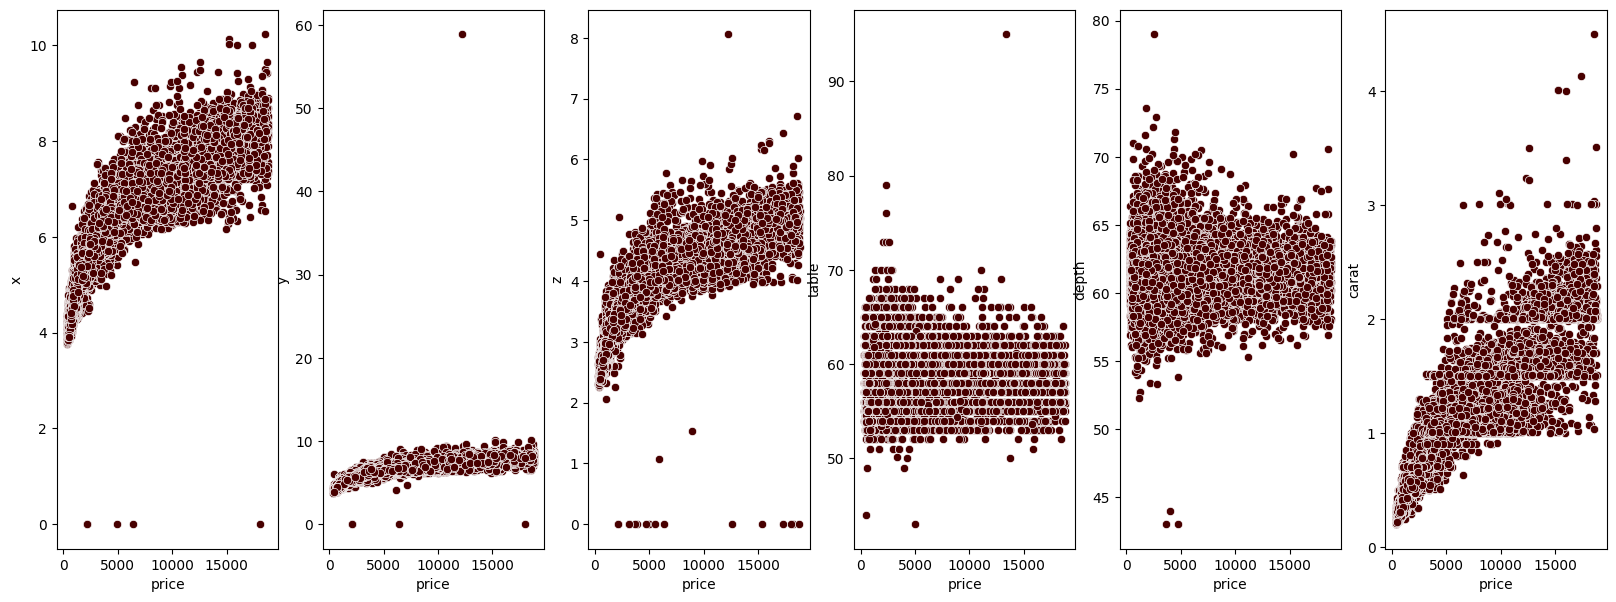

In [61]:
# Plot the data distribution of numerical variables
def distribution(df):
    cols = ['x','y','z','table','depth', 'carat']
    c = 0
    fig, axs = plt.subplots(ncols = len(cols), figsize=(20,7))
    for i in cols :
        sns.scatterplot(data = df,x = df['price'],y = df[i], ax = axs[c])
        c+=1

distribution(diamond_df)

In [111]:
# Check if there is duplicated numbers
diamond_df[diamond_df.duplicated()]

,cut,color,clarity,price,city,carat,depth,table,x,y,z
13100,Ideal,J,VVS2,662,Surat,0.40,61.8,55.0,4.76,4.79,2.95
16095,Good,E,SI2,1783,Surat,0.71,57.5,58.0,5.91,5.89,3.39
16321,Good,I,SI2,18242,Kimberly,3.01,63.9,60.0,9.06,9.01,5.77
16757,Premium,F,VVS2,8924,Surat,1.00,60.6,54.0,6.56,6.52,3.96
25377,Premium,E,SI2,4967,Antwerp,1.10,59.1,60.0,6.77,6.70,3.98
28989,Good,I,SI1,10184,Kimberly,2.01,64.1,60.0,7.92,7.88,5.06
31198,Premium,F,VS1,982,Surat,0.40,61.4,58.0,4.73,4.75,2.91
31822,Premium,E,SI2,984,Kimberly,0.53,62.2,57.0,5.20,5.16,3.22
32164,Ideal,H,VVS2,828,Madrid,0.32,61.8,55.0,4.42,4.38,2.72
38196,Ideal,D,VS2,972,Madrid,0.32,61.6,56.0,4.40,4.37,2.70


In [132]:
# Detect 
conteo_clases = diamond_df['cut'].value_counts()
conteo_clases

cut
Ideal        16220
Premium      10260
Very Good     9095
Good          3663
Fair          1217
Name: count, dtype: int64

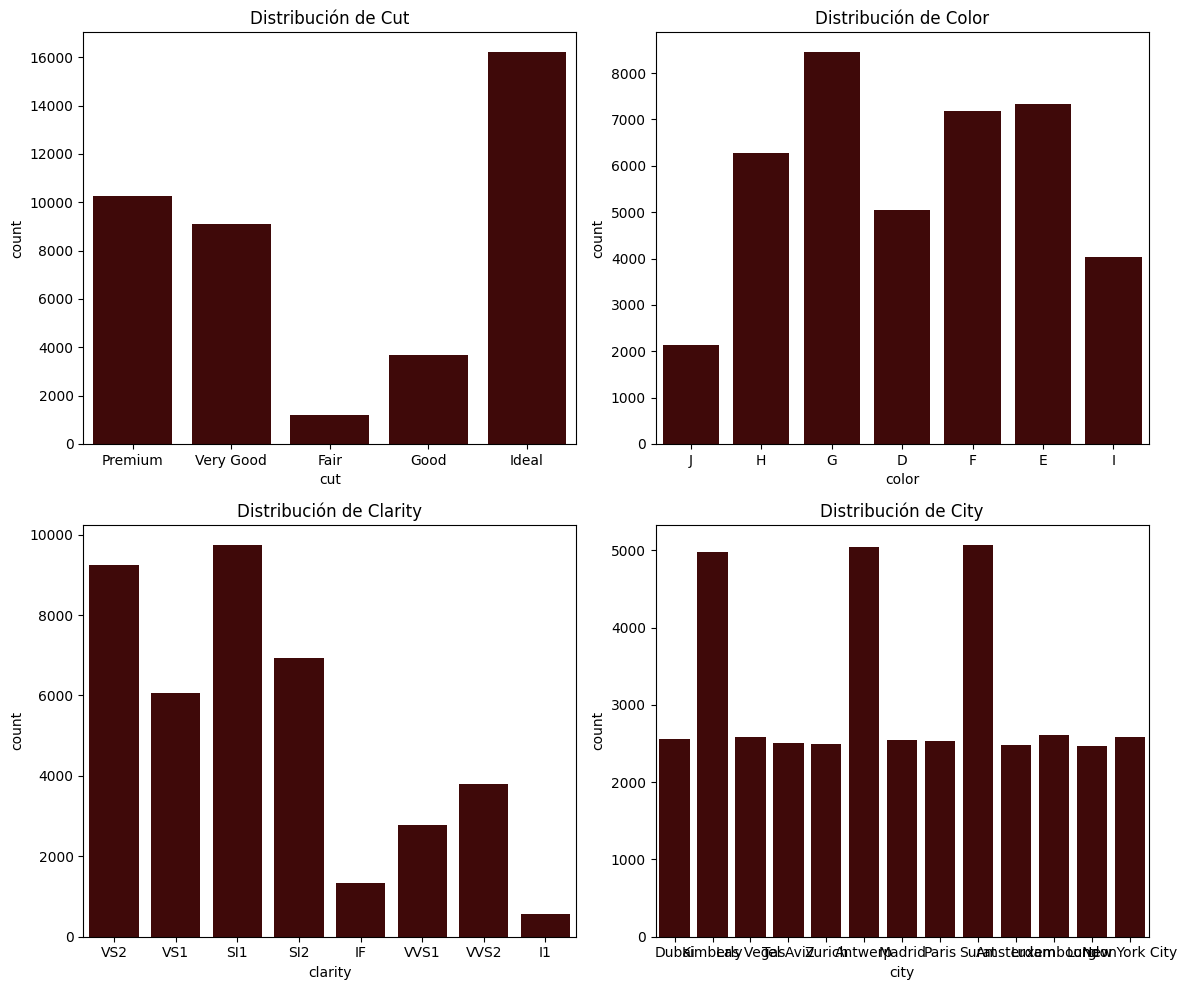

In [134]:
# View the distribution of the records in the categorical variables
# Size graphic configuration
plt.figure(figsize=(12, 10))

# 'cut' graphic
plt.subplot(221)
sns.countplot(data=diamond_df, x='cut')
plt.title('Distribución de Cut')

# 'color' graphic
plt.subplot(222)
sns.countplot(data=diamond_df, x='color')
plt.title('Distribución de Color')

# 'clarity' graphic
plt.subplot(223)
sns.countplot(data=diamond_df, x='clarity')
plt.title('Distribución de Clarity')

# 'city' graphic
plt.subplot(224)
sns.countplot(data=diamond_df, x='city')
plt.title('Distribución de City')

# Plot the graphic
plt.tight_layout()
plt.show()

## Data transformation: numeric values

In [94]:
# Sort the dataframe columns
diamond_df = diamond_df[['cut', 'color', 'clarity', 'city', 'carat', 'depth', 'table', 'x', 'y', 'z', 'price']]

### VERSION 1: diamond_df_v1
The following changes are made in this version:
- Step 1: remove records where the x,y,z columns are worth 0. 
- Step 2: remove the outliers.
- Step 3: remove duplicated data.
It may make sense, because only 24 records out of 40455 are deleted.

In [95]:
# Step 1: 
diamond_df_v1 = diamond_df.drop(diamond_df[diamond_df['x'] == 0].index)
diamond_df_v1 = diamond_df.drop(diamond_df[diamond_df['y'] == 0].index)
diamond_df_v1 = diamond_df.drop(diamond_df[diamond_df['z'] == 0].index)
diamond_df_v1.shape

(40439, 11)

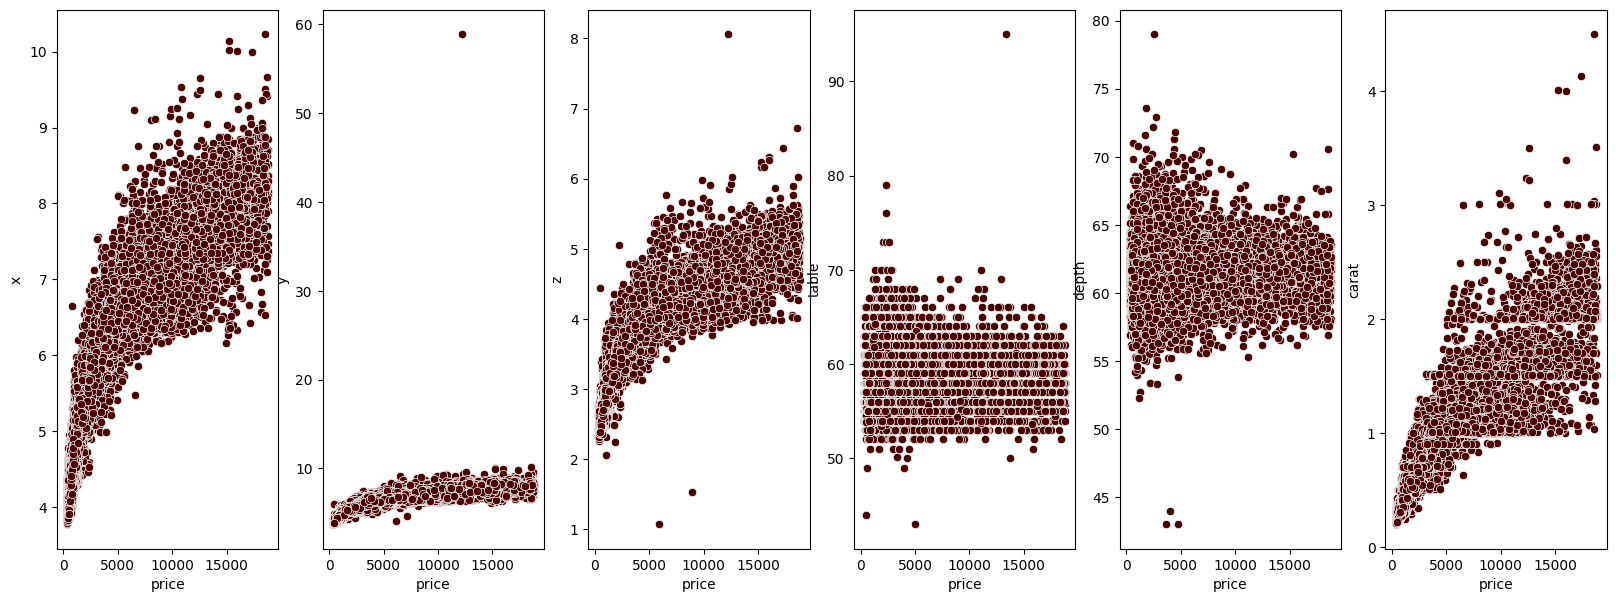

In [96]:
distribution(diamond_df_v1)

In [97]:
# Step 2:
diamond_df_v1 = diamond_df_v1[(diamond_df_v1['x'] < 30)]
diamond_df_v1 = diamond_df_v1[(diamond_df_v1['y'] < 30)]
diamond_df_v1 = diamond_df_v1[(diamond_df_v1['z'] < 7.5) & (diamond_df_v1['z'] > 2)]
diamond_df_v1 = diamond_df_v1[(diamond_df_v1['table'] < 80) & (diamond_df_v1['table'] > 40)]
diamond_df_v1 = diamond_df_v1[(diamond_df_v1['depth'] < 75) & (diamond_df_v1['depth'] > 45)]
diamond_df_v1.shape

(40431, 11)

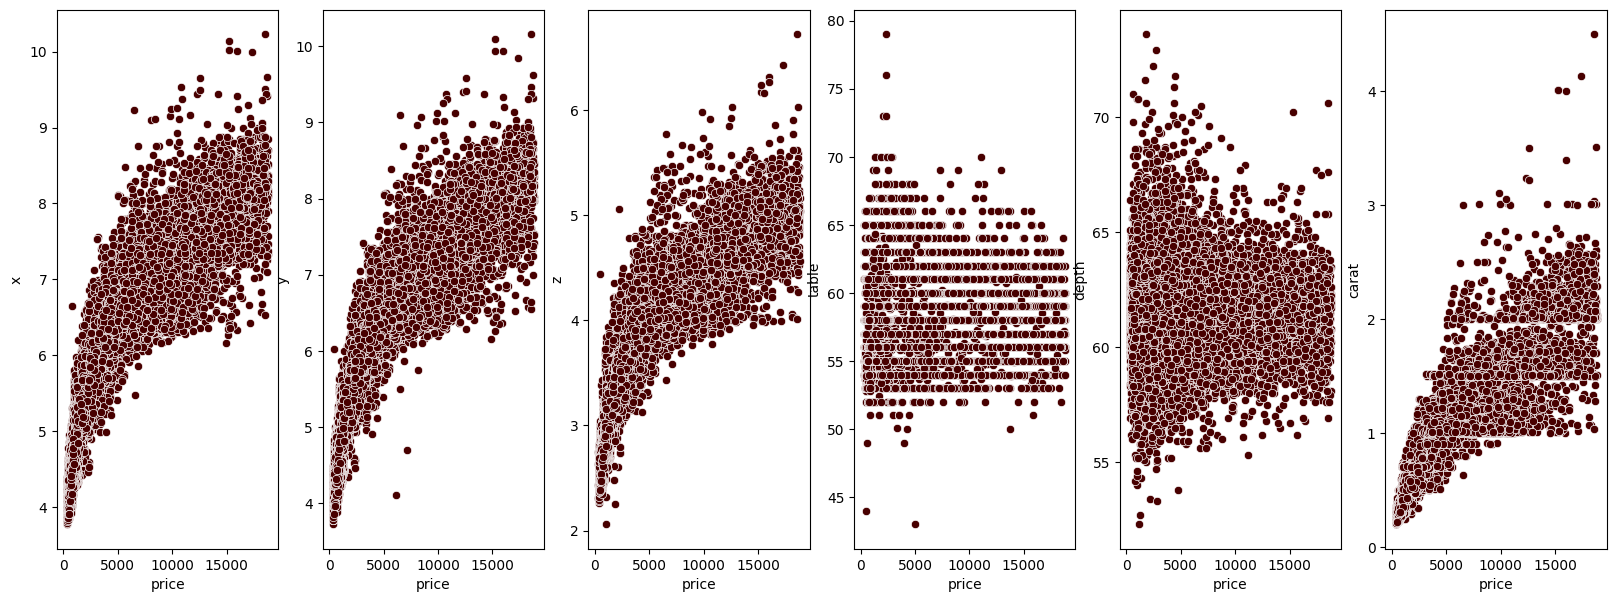

In [98]:
distribution(diamond_df_v1)

In [113]:
# Step 3:
diamond_df_v1 = diamond_df_v1.drop_duplicates()
diamond_df_v1.shape

(40421, 11)

### VERSION 2: diamond_df_v2
The following changes are made in this version:
- Transform records where the x,y,z columns are worth 0. I will use a simple imputation, substituting these values for the median.
- No remove the outliers.

In [99]:
diamond_df_v2 = diamond_df.copy()

In [100]:
# Calculate the median of each column
median_x = diamond_df_v2.loc[diamond_df_v2['x'] != 0, 'x'].median()
median_y = diamond_df_v2.loc[diamond_df_v2['y'] != 0, 'y'].median()
median_z = diamond_df_v2.loc[diamond_df_v2['z'] != 0, 'z'].median()

# Replace values equal to 0 by the corresponding median.
diamond_df_v2['x'] = diamond_df_v2['x'].replace(0, median_x)
diamond_df_v2['y'] = diamond_df_v2['y'].replace(0, median_y)
diamond_df_v2['z'] = diamond_df_v2['z'].replace(0, median_z)
diamond_df_v2.shape

(40455, 11)

In [101]:
zero_count(diamond_df_v2)

Número de ceros en la columna 'x': 0
Número de ceros en la columna 'y': 0
Número de ceros en la columna 'z': 0


## Data transformation: categorical values
There are three categorical variables (colors, cuts and clarity), which must be transformed into numerical values in order to work with them. Since the three categorical variables have several classes (7, 5 and 8 respectively) label encoding will be used, in order not to create so many columns as it would be done with one hot encoding.
### VERSION 1: diamond_df_v1

In [193]:
# Features + target (encoding). IMPORTANT: you may pick any of the 2-labeled features as you target (choose wisely!!!)
def encoder(df):
    df_enc = df.copy()

    # Obtain the dataframe encoded
    for column in df.columns:
        if df[column].dtype == 'object':
            enc_label = LabelEncoder()
            df_enc[column] = enc_label.fit_transform(df[column])
    return df_enc

diamond_df_enc_v1 = encoder(diamond_df_v1)
diamond_df_enc_v1.shape

(40421, 11)

In [194]:
diamond_df_enc_v1.head()

,cut,color,clarity,city,carat,depth,table,x,y,z,price
0,3,6,5,2,1.21,62.4,58.0,6.83,6.79,4.25,4268
1,4,4,5,3,0.32,63.0,57.0,4.35,4.38,2.75,505
2,0,3,4,4,0.71,65.5,55.0,5.62,5.53,3.65,2686
3,1,0,2,3,0.41,63.8,56.0,4.68,4.72,3.00,738
4,2,3,2,2,1.02,60.5,59.0,6.55,6.51,3.95,4882


### VERSION 2: diamond_df_v2

In [158]:
diamond_df_enc_v2 = encoder(diamond_df_v2)
diamond_df_enc_v2.shape

(40455, 11)

In [159]:
diamond_df_enc_v2.head()

,cut,color,clarity,city,carat,depth,table,x,y,z,price
0,3,6,5,2,1.21,62.4,58.0,6.83,6.79,4.25,4268
1,4,4,5,3,0.32,63.0,57.0,4.35,4.38,2.75,505
2,0,3,4,4,0.71,65.5,55.0,5.62,5.53,3.65,2686
3,1,0,2,3,0.41,63.8,56.0,4.68,4.72,3.00,738
4,2,3,2,2,1.02,60.5,59.0,6.55,6.51,3.95,4882


## Feature ingeniering:
Create new features which can impruve the prediction
### VERSION 1: diamond_df_v1

In [195]:
# Function to create new features:
def feature_ing(df_features):
    # Test the depth calculate
    df_features['depth(mm)'] = (df_features['z']*2)/(df_features['x'] + df_features['y'])
    # Obtain the average girdle diameter
    df_features['avg_girdle'] = (df_features['z'])/(df_features['depth(mm)'])
    # Obtain table in mm
    df_features['table(mm)'] = (df_features['avg_girdle'])*(df_features['table'])/100
    # Obtain table*depth
    df_features['table_depth'] = (df_features['table'])/(df_features['depth'])
    # Obtain x, y, z
    df_features['xyz'] = (df_features['x'])*(df_features['y'])*(df_features['z'])
    return df_features

diamond_df_trans_v1 = feature_ing(diamond_df_enc_v1)
diamond_df_trans_v1.head()

,cut,color,clarity,city,carat,depth,table,x,y,z,price,depth(mm),avg_girdle,table(mm),table_depth,xyz
0,3,6,5,2,1.21,62.4,58.0,6.83,6.79,4.25,4268,0.624082,6.810,3.94980,0.929487,197.096725
1,4,4,5,3,0.32,63.0,57.0,4.35,4.38,2.75,505,0.630011,4.365,2.48805,0.904762,52.395750
2,0,3,4,4,0.71,65.5,55.0,5.62,5.53,3.65,2686,0.654709,5.575,3.06625,0.839695,113.436890
3,1,0,2,3,0.41,63.8,56.0,4.68,4.72,3.00,738,0.638298,4.700,2.63200,0.877743,66.268800
4,2,3,2,2,1.02,60.5,59.0,6.55,6.51,3.95,4882,0.604900,6.530,3.85270,0.975207,168.429975


In [178]:
diamond_df_trans_v1.shape

(40421, 16)

### VERSION 2: diamond_df_v2

In [176]:
# Function to create new features:
diamond_df_trans_v2 = feature_ing(diamond_df_enc_v2)
diamond_df_trans_v2.head()

,cut,color,clarity,city,carat,depth,table,x,y,z,price,depth(mm),avg_girdle,table(mm),table_depth,xyz
0,3,6,5,2,1.21,62.4,58.0,6.83,6.79,4.25,4268,0.624082,6.810,3.94980,0.929487,197.096725
1,4,4,5,3,0.32,63.0,57.0,4.35,4.38,2.75,505,0.630011,4.365,2.48805,0.904762,52.395750
2,0,3,4,4,0.71,65.5,55.0,5.62,5.53,3.65,2686,0.654709,5.575,3.06625,0.839695,113.436890
3,1,0,2,3,0.41,63.8,56.0,4.68,4.72,3.00,738,0.638298,4.700,2.63200,0.877743,66.268800
4,2,3,2,2,1.02,60.5,59.0,6.55,6.51,3.95,4882,0.604900,6.530,3.85270,0.975207,168.429975


In [179]:
diamond_df_trans_v2.shape

(40455, 16)

## Study of the correlation between variables

### VERSION 1: diamond_df_v1
Remove the variables without correlation with the prize column: ['cut', 'clarity', 'city', 'depth', 'depth(mm)']

In [227]:
# Function to delete features without correlation with price
def delete_features(df):
    # Calculate correlation matrix, round with two decimmals
    corr_matrix = round(df.corr(numeric_only=True).abs(),2)
    
    # Plot the heatmap
    #sns.set (rc = {'figure.figsize':(16, 6)})
    #sns.heatmap(corr_matrix, center=0, cmap='BrBG', annot=True)

    # Find features with correlation greater than 0.90
    to_drop = corr_matrix.columns[corr_matrix['price'] <= 0.1]
    print(to_drop)
    print(type(to_drop))

    # Drop features
    df_correct = df
    df_correct.drop(to_drop, axis=1, inplace=True)
    
    return df_correct

diamond_df_trans_v1_copy = diamond_df_trans_v1.copy() 
diamond_df_red_v1 = delete_features(diamond_df_trans_v1_copy)

Index(['cut', 'clarity', 'city', 'depth', 'depth(mm)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>


<Axes: >

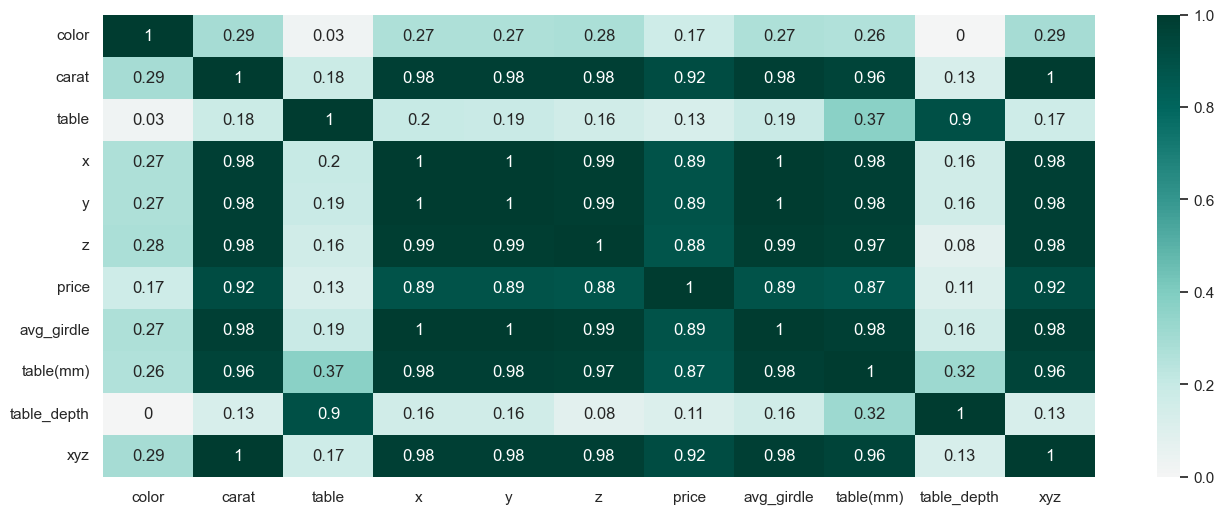

In [205]:
# Plot the heatmap
corr_matrix = round(diamond_df_red_v1.corr(numeric_only=True).abs(),2)
sns.set (rc = {'figure.figsize':(16, 6)})
sns.heatmap(corr_matrix, center=0, cmap='BrBG', annot=True)

In [207]:
diamond_df_trans_v2_copy = diamond_df_trans_v2.copy() 
diamond_df_red_v2 = delete_features(diamond_df_trans_v2_copy)

Index(['cut', 'clarity', 'city', 'depth', 'depth(mm)'], dtype='object')


## Scaling
### VERSION 1: diamond_df_v1

In [220]:
X_v1 = diamond_df_red_v1.drop(columns=['price'])  # Features
y_v1 = diamond_df_red_v1['price']  # Target

scaler = StandardScaler()
# Scale X
X_v1_scaled = scaler.fit_transform(X_v1)
# Scale y. With reshape function, we are converting y_v1 into a single column matrix, i.e., one column and as many rows as 
# it originally had elements. With flatten, this flattens the resulting array.
y_v1_scaled = scaler.fit_transform(y_v1.values.reshape(-1, 1)).flatten()

### VERSION 2: diamond_df_v2

In [221]:
X_v2 = diamond_df_red_v2.drop(columns=['price'])  # Features
y_v2 = diamond_df_red_v2['price']  # Target

scaler = StandardScaler()
# Scale X
X_v2_scaled = scaler.fit_transform(X_v2)
# Scale y. With reshape function, we are converting y_v1 into a single column matrix, i.e., one column and as many rows as 
# it originally had elements. With flatten, this flattens the resulting array.
y_v2_scaled = scaler.fit_transform(y_v2.values.reshape(-1, 1)).flatten()

## Studying the data

In [ ]:
# - Utilizar métodos de clasificación para ver si detecta más clases en las variables categóricas, por si pudiera crear 
#    alguna más.
# - Representar corr en mapa de calor para ver que valores no aporta información al cálculo del precio.
# - Dijo octavio que había una variable que se podía calcular en la que se utilizaba table y otra variable.
# - Estudiar qué variables se pueden crear con respecto a los diamantes.
# - Hacer el umap para reducir dimensionalmente la matriz.
# - Escalar los datos y hacer dos dataset con cada escalador.